In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from PIL import Image, ImageDraw

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/test_256bs_200epoch_layer3_L11e-3'
model_path = os.path.join(PATH, 'saved_model.pt')

In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def load_model(model_path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    print('Successfully Load Model: ', os.path.basename(model_path))
    return model

In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()
def get_weights(model):
    conv_layers_weights = dict()
    for name, param in model.named_parameters():
#         print(name,param.shape)
        conv_layers_weights[name] = param
        if name == 'module.mask':
            return param

In [6]:
def predict_model(PATH):
    model = load_model(PATH)
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #forward
        outputs, pre, reg = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)
        # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
        # print ('group loss:',group_loss[0])
        y = labels.data
        batch_size = labels.data.shape[0]
        # print(y.resize_(batch_size,1))
        running_corrects += torch.sum(preds == y)
        # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
        epoch_acc = float(running_corrects) /dataset_sizes[phase]
        true_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    
    #Draw weights
    weights = get_weights(model)
    weights = weights.cpu().detach().numpy()
    weights = np.transpose(weights)
    print(weights.shape)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    im = ax.imshow(weights,cmap=plt.cm.jet)
    plt.colorbar(im,orientation='vertical')
    plt.title('ICNN Model')
    plt.show()
    return true_labels, model_preds

In [8]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
def plot_confusion_matrix_and_text(cm, labels_name, title):
    plt.figure(figsize=(16,16),dpi=200)
    plt.subplot(221)
    plot_confusion_matrix(cm, labels_name, title)
    plt.subplot(222)
    
    text_img = Image.new('RGB', (350, 250), color = (255,255,255))
    d = ImageDraw.Draw(text_img)
    text_content = classification_report(true_labels, model_preds, target_names=labels_name)
    d.text((0,0), text_content, fill=(0,0,0))
    plt.imshow(text_img)
    plt.show()

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8681
(10, 64)


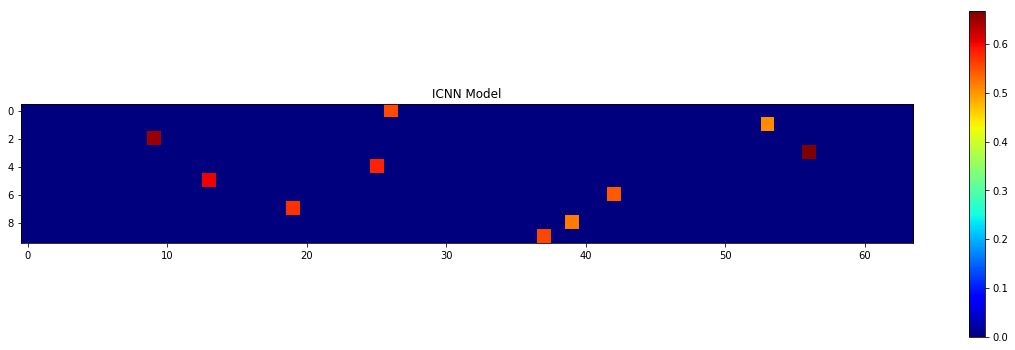

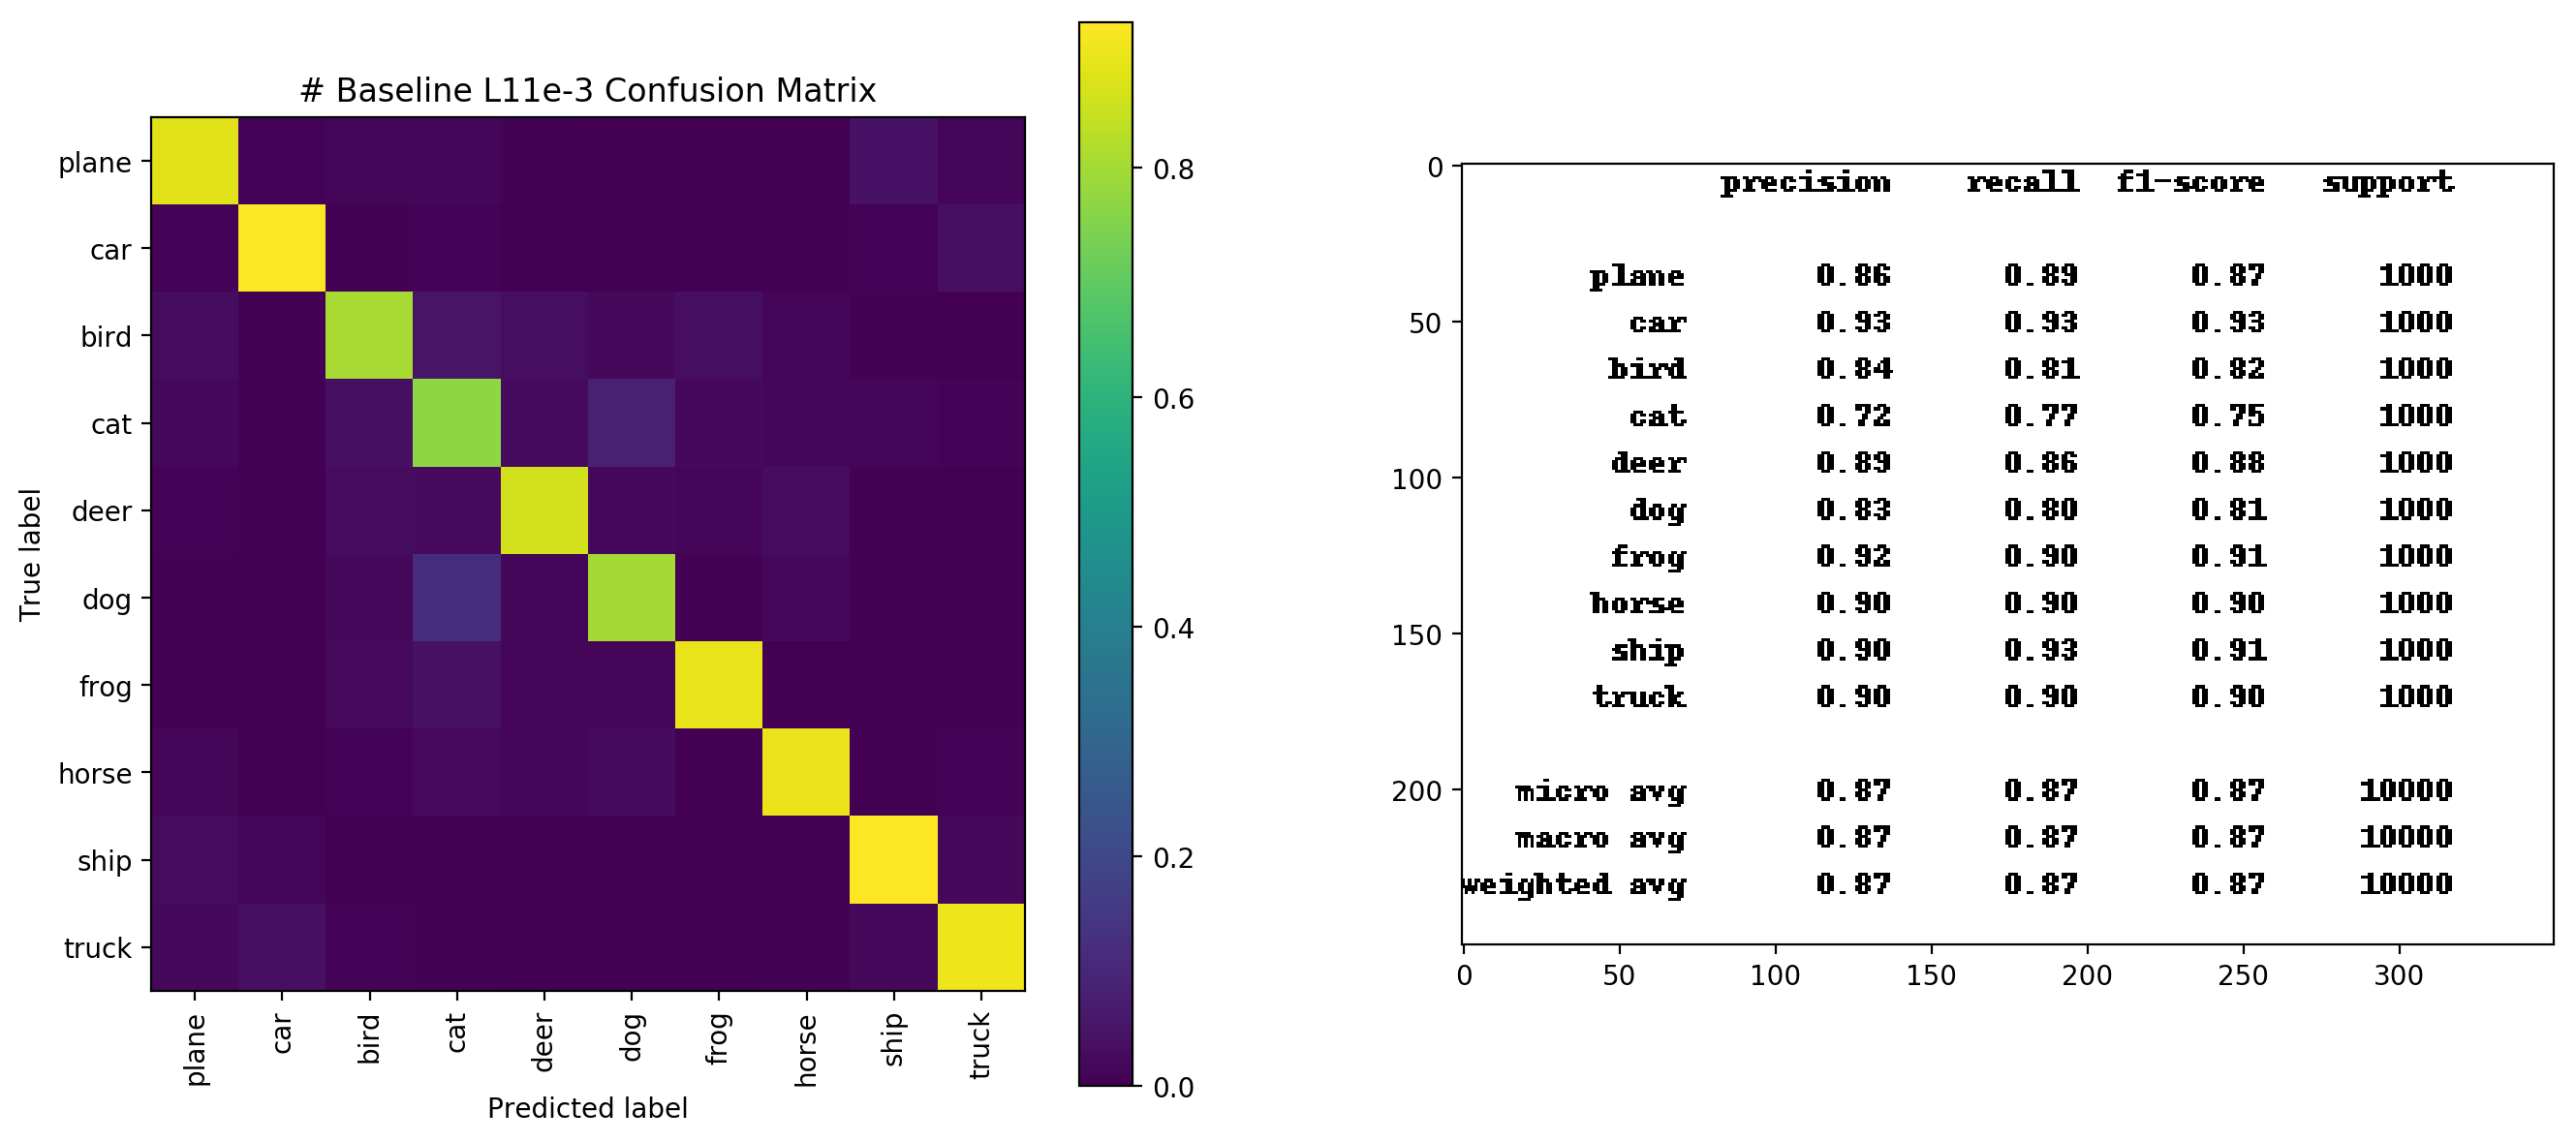

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,887,10,18,15,6,1,3,3,44,13
1,8,927,4,10,1,2,0,1,8,39
2,32,5,806,49,34,21,33,13,6,1
3,19,0,38,770,27,84,21,18,14,9
4,10,0,32,26,865,20,11,30,4,2
5,7,1,20,120,18,801,5,21,4,3
6,5,1,22,40,14,13,898,2,2,3
7,14,1,10,23,12,26,3,900,1,10
8,29,11,3,3,0,2,5,3,925,19
9,20,38,8,7,0,0,1,4,20,902


In [9]:
PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/test_256bs_200epoch_layer3_L11e-3'
model_path = os.path.join(PATH, 'saved_model.pt')
true_labels, model_preds = predict_model(model_path)
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "# Baseline L11e-3 Confusion Matrix")
plt.show() 
table = pd.DataFrame(cm)
table.columns = labels_name
table